# Emperor Penguin accessibility per grid cell - PRESENT DAY
- Calculate how many Emperor penguins can reach each CESM grid cells and save as netcdf file.
- Notebook by Alice DuVivier (NCAR)
- October 2024

## Steps for Colonies

1) Load distance from colonies to each grid cell and initial "present day" population at each colony

2) Assume that # individuals who can reach a grid point drops off exponentially. $y = y_0*e^{-Ax}$ where y is the # individuals, $y_0$ is the colony population, and x is the distance.
- For EP we are using the **average foraging distance** - 428km (need citation from Stef).
- Since this is an average foraging distance, we assume that 1/2 of all individuals in a colony could reach that distance ($y = 0.5y_0$ @ x = avg_dist). Thus, the decay rate will be $A = -\frac{1}{x}ln(0.5)$. This is the same rate for all colonies.
- Note that we're assuming a radial distance for foraging but this was probably not a linear distance traveled

3) Sum up for each grid cell how many individuals can potentially access that cell from all colonies within foraging range.
- Cells that are within range of multiple colonies will be most important for that species.

In [1]:
import utils
import pandas as pd
import xarray as xr
import numpy as np
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

In [2]:
# define exponential decline function for how many individuals can access a grid cell
from math import log, exp
def decline(pop_tot, dist_max):
    rate = -log(0.5)/dist_max
    return rate

## Read in Emperor colony data

In [4]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [5]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_colony_present_day.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

In [6]:
ds_ep = ds_ep.rename({'index':'colonies'})

In [7]:
# get data we'll need for this
dist_colony = ds_ep.colony_distance
pop_colony = ds_ep.colony_pop

In [8]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_ep.nlon)
ylen = len(ds_ep.nlat)
clen = len(ds_ep.colonies)
print(xlen,ylen,clen)

320 36 66


## Read in Grid data

In [9]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [10]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [11]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [12]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Calculate how many penguins can reach each grid cell

In [29]:
# set EP average foraging distance (km)
rr = 428

In [14]:
# loop through colonies to calculate individuals for that colony
individuals = np.zeros([clen,ylen,xlen])

for col in np.arange(0,clen,1):
    pop = pop_colony.isel(colonies=col)
    dist = dist_colony.isel(colonies=col)
    # get decline rate for this colony
    rate = decline(pop,rr)
    # calculate how many individuals from the colony can reach each point
    individuals[col,:,:] = pop * np.exp(-rate*dist)

# convert to xarray
individuals = xr.DataArray(individuals,dims=('colonies','nlat','nlon'))
individuals.attrs['units'] = 'number of emperor penguins'
individuals['colonies'] = ds_ep.colonies
individuals['nlat'] = ds_ep.nlat
individuals['nlon'] = ds_ep.nlon

In [17]:
# omit land points
individuals_keep = individuals.where(ds_grid.REGION_MASK == 1)

In [18]:
# sum over all colonies
total_ep = individuals_keep.sum(dim='colonies')

# omit land points
total_ep = total_ep.where(ds_grid.REGION_MASK == 1)

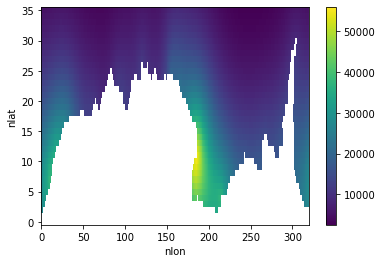

In [19]:
total_ep.plot()

## Put together into one dataset

- Netcdf with variable dimension: (nlat x nlon)
- Keep the total penguins that can access a cell in present day

In [30]:
ds_out = xr.Dataset()

ds_out['total_penguins'] = total_ep

ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Present day number of Emperor penguins who can access each grid point.'

ds_out

<xarray.Dataset>
Dimensions:         (nlat: 36, nlon: 320)
Coordinates:
  * nlat            (nlat) int64 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * nlon            (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
    ULONG           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    total_penguins  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-10-07
    contents:        Present day number of Emperor penguins who can access ea...

In [31]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	nlat: (36,)
	nlon: (320,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201

## Export and Save

In [32]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.00 GB.


In [33]:
path_out = path_in
file_out = 'CESM_grid_Emperor_individual_access_present_day.nc'
fout = path_out + file_out

In [34]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)